In [10]:
from invisible_cities.cities.components import deconv_pmt
import pandas as pd
import numpy as np
import tables as tb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [8]:
def sum_wf(wfs):
    element_wise_sum = np.zeros_like(wfs[0])

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def ADC_to_PE(wfs, datapmt):
    conv_factors = datapmt.adc_to_pes.to_numpy()

    for w in range(0, len(wfs)):
        if (conv_factors[w] == 1e5):
            conv_factors[w] = 0
        wfs[w] = wfs[w]*conv_factors[w]

    return wfs


def check_summed_baseline(wfs_sum, grass_lim, scale_factor):

    flag=False
    tc=25e-3
    
    # Check the baseline at the end and start match
    # otherwise there could be signal there so the baseline is all messed up
    num_samples = int(25/tc)
    baseline1=np.mean(wfs_sum[-num_samples:])
    baseline2=np.mean(wfs_sum[0:int(25/tc)])

    # 20 seems like a good number to check the difference against
    if (abs(baseline1-baseline2) > 20*scale_factor):
        print("Error in baselines at start and end, dropping event")
        print(baseline1-baseline2)
        flag = True

    return flag

# Fit the distribution 
def Gaussian(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

def FitS2(time, amplitude):
    max_amplitude = np.max(amplitude)
    half_max = max_amplitude / 2

    # Find indices where amplitude crosses half-maximum level
    above_half_max = np.where(amplitude >= half_max)[0]

    time_slice = time[above_half_max]
    # print(time_slice)
    

    # Perform the curve fit
    params, covariance = curve_fit(Gaussian, time[above_half_max], amplitude[above_half_max], bounds = ([1e3, min(time_slice),1], [8.5e8, max(time_slice),50]))

    # Extract the fitted parameters
    A, mu, sigma = params
    print(A, mu, sigma )

    return A, mu, sigma

def find_highest_sipm(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    index = np.argmax(np.max(wfs, axis=1))
    print(index)
    return index

In [3]:
filename  = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"

raw_evts = pd.read_hdf(filename, '/Run/events')
event_list = raw_evts.evt_number.unique()
nrwfs = len(event_list)
print(event_list)
print("Number of Waveforms:", nrwfs)


[  2   9  16  23  30  37  44  51  58  65  72  79  86  93 100 107 114 121
 128 135 142 149 156 163 170 177 184 191 198 205 212 219 226 233 240 247
 254 261 268 275 282 289 296 303 310 317 324 331 338 345 352 359 366 373
 380 387 394 401 408 415 422 429 436 443 450 457 464 471 478 485 492 499
 506 513 520 527 534 541 548 555 562 569 576 583 590 597]
Number of Waveforms: 86


In [6]:
# Load in the database for SiPMs

RUN_NUMBER = 13852
# RUN_NUMBER = 14180
# RUN_NUMBER = 14498
# RUN_NUMBER = 14584

deconv = deconv_pmt("next100", RUN_NUMBER, 62400)

detector_db = "next100"
datasipm = load_db.DataSiPM(detector_db, RUN_NUMBER)
datapmt = load_db.DataPMT(detector_db, RUN_NUMBER)

display(datasipm)

tc          = 25e-3  # constant to convert from samples to time or vice versa. 
noise_sigma = 4      # how many STD above noise for the single PEs to be
scale_factor = 40*60 # Scale factor for summed waveform. 60 Pmts, 40 is ~ the conversion factor

dead_pmts = [3, 16, 24, 36, 37, 38, 39,40, 41, 48, 53, 58]

if (RUN_NUMBER == 13850 or RUN_NUMBER == 13852):
    noise_lim   = 1900, 2000 # time window to calculate the noise baseline
    S1_height   = 10000
    S2_height   = 50000
    S2_start    = 990        # S2 integration window start
    S2_end      = 1040       # S2 integration window end
    S1_window   = 100, 985   # window to search for S1
    S2_window   = 985, 1200  # window to search for S2

else:
    print("Unknown RUN Configured")


useRaw = False



,SensorID,ChannelID,Active,X,Y,adc_to_pes,Sigma
0,1000,36013,1,-482.625,-294.825,14.57,2.24
1,1001,36012,1,-482.625,-279.275,15.97,2.24
2,1002,36015,1,-482.625,-263.725,14.66,2.24
3,1003,36014,1,-482.625,-248.175,12.30,2.24
4,1004,36029,1,-482.625,-232.625,14.92,2.24
...,...,...,...,...,...,...,...
3579,56059,49054,1,490.025,245.425,14.25,2.24
3580,56060,49037,1,490.025,260.975,14.89,2.24
3581,56061,49036,1,490.025,276.525,15.10,2.24
3582,56062,49039,1,490.025,292.075,14.43,2.24


On index: 0 2
On index: 1 9
On index: 2 16
1688
x,y pos: -65.775 260.475
59926.92961492769 1008.9686813649841 5.976755756782019
Area under the Gaussian: 897795.59
On index: 3 23
On index: 4 30
On index: 5 37
On index: 6 44
On index: 7 51
On index: 8 58
On index: 9 65
On index: 10 72
On index: 11 79
On index: 12 86
On index: 13 93
On index: 14 100
On index: 15 107
On index: 16 114
On index: 17 121
On index: 18 128
On index: 19 135
On index: 20 142
On index: 21 149
On index: 22 156
On index: 23 163
On index: 24 170
On index: 25 177
On index: 26 184
On index: 27 191
On index: 28 198
On index: 29 205
On index: 30 212
On index: 31 219
On index: 32 226
On index: 33 233
On index: 34 240
On index: 35 247
On index: 36 254
On index: 37 261
On index: 38 268
On index: 39 275
On index: 40 282
On index: 41 289
On index: 42 296
On index: 43 303
On index: 44 310
On index: 45 317
On index: 46 324
On index: 47 331
On index: 48 338
On index: 49 345
On index: 50 352
On index: 51 359
On index: 52 366
On in

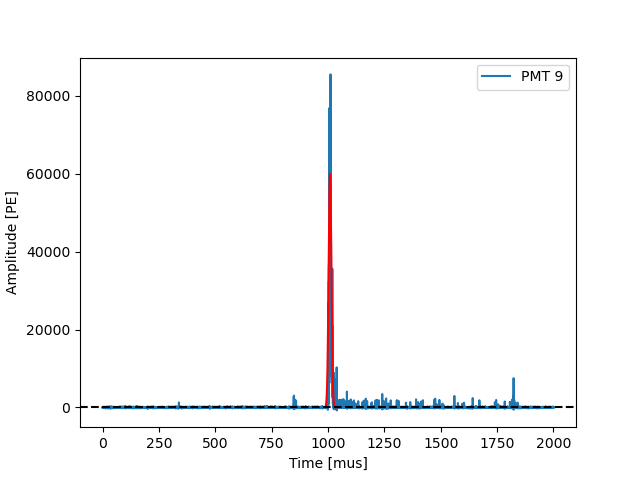

In [14]:
%matplotlib widget

event_number = 2

# highest = highest PMT waveform, "summed" = summed waveform across all PMT, "1-60" select PMT number for a specific pmt
plot_mode = "highest"
# plot_mode = "summed"
# plot_mode = "13"

# Open the file
with tb.open_file(filename) as file:

    # Get the raw waveforms from the file
    rwf      = file.root.RD.pmtrwf

    # Event loop
    for evt_no, wfs in enumerate(rwf):

        print("On index:", evt_no, event_list[evt_no])
        
        # For plotting only one event rather than loop
        if (evt_no != event_number):
            continue

        # Do deconvolution or not on the waveform
        if ( useRaw):
            wfs = CorrectRawBaseline(wfs)
        else:
            wfs = deconv(wfs)

        # Convert the ADC to PE
        wfs = ADC_to_PE(wfs, datapmt)

        # Zero out the dead PMTs
        for pmt_ in dead_pmts:
            wfs[pmt_] = np.arange(wfs[pmt_] .size) * 0
        

        # Get the x,y pos from the SiPms
        highest_sipm = find_highest_sipm(file.root.RD.sipmrwf, event_number)
        x_pos = datasipm.iloc[highest_sipm].X
        y_pos = datasipm.iloc[highest_sipm].Y
        print("x,y pos:", x_pos, y_pos)

        # Choose which waveform to plot
        if (plot_mode == "highest"):
            index = np.argmax(np.max(wfs, axis=1))
            wf_pmt = wfs[index]
            plot_mode = index
        elif (plot_mode == "summed"):
            wf_pmt =  sum_wf(wfs)
        else:
            wf_pmt = wfs[int(plot_mode)]

        # Fit the S2 with a Gauss
        A, mu, sigma = FitS2(times[int(S2_start/tc):int(S2_end/tc)], wf_pmt[int(S2_start/tc):int(S2_end/tc)])
        area = A * sigma * np.sqrt(2 * np.pi)
        print(f"Area under the Gaussian: {area:.2f}")
        S2_time_window = np.linspace(S2_start, S2_end,500)


        # Plotting
        plt.figure()
        
        sp_pmt  = 25e-3 # sampling period in mus
        times   = np.arange(wfs[0] .size) * sp_pmt
        plt.plot(times, wf_pmt , label = f"PMT {plot_mode}");
        plt.ylabel("Amplitude [PE]")
        plt.xlabel("Time [mus]")

        plt.plot(S2_time_window, Gaussian(S2_time_window, A,mu,sigma), color="red") # plot Gaussian S2 Fit

        plt.axhline(y=0, color='black', linestyle='--') # plot zero horizontal
        plt.legend(loc = "upper right")

        # plt.xlim(1590,1650)
        # plt.ylim(10,5e6)
        # plt.semilogy()
        
        # plt.savefig(f"../plots/deconvolved/run_{RUN_NUMBER}_event{evt_no}.png")
